# My own version of lesson1: dogs vs cats redux 

In [1]:
#!pip install 'keras<2'

In [2]:
#!pip install 'h5py'

In [3]:
#!pip install panda

In [4]:
%matplotlib inline

Define path to data: (It's a good idea to put it in a subdirectory of your notebooks folder, and then exclude that directory from git control by adding it to .gitignore.)

In [5]:
%pwd
#%cd fastai_courses/deeplearning1/nbs

u'/home/ubuntu/fastai_courses/deeplearning1/nbs'

# Working on sample data

In [6]:
# path = "data/dogscats/"
path = "data/dogscatsredux/sample/"

A few basic libraries that we'll need for the initial exercises:

In [7]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

We have created a file most imaginatively called 'utils.py' to store any little convenience functions we'll want to use. We will discuss these as we use them.

In [8]:
import utils; reload(utils)
from utils import plots

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


# Use a pretrained VGG model with our **Vgg16** class

Our first step is simply to use a model that has been fully created for us, which can recognise a wide variety (1,000 categories) of images. We will use 'VGG', which won the 2014 Imagenet competition, and is a very simple model to create and understand. The VGG Imagenet team created both a larger, slower, slightly more accurate model (*VGG  19*) and a smaller, faster model (*VGG 16*). We will be using VGG 16 since the much slower performance of VGG19 is generally not worth the very minor improvement in accuracy.

We have created a python class, *Vgg16*, which makes using the VGG 16 model very straightforward. 

## The punchline: state of the art custom model in 7 lines of code

Here's everything you need to do to get >97% accuracy on the Dogs vs Cats dataset - we won't analyze how it works behind the scenes yet, since at this stage we're just going to focus on the minimum necessary to actually do useful work.

In [9]:
# As large as you can, but no larger than 64 is recommended. 
# If you have an older or cheaper GPU, you'll run out of memory, so will have to decrease this.
batch_size=8

In [10]:
# Import our class, and instantiate
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [11]:
vgg = Vgg16()
# Grab a few images at a time for training and validation.
# NB: They must be in subdirectories named based on their category
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size)

Found 1999 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


## Use our Vgg16 class to finetune a Dogs vs Cats model

To change our model so that it outputs "cat" vs "dog", instead of one of 1,000 very specific categories, we need to use a process called "finetuning". Finetuning looks from the outside to be identical to normal machine learning training - we provide a training set with data and labels to learn from, and a validation set to test against. The model learns a set of parameters based on the data provided.

However, the difference is that we start with a model that is already trained to solve a similar problem. The idea is that many of the parameters should be very similar, or the same, between the existing model, and the model we wish to create. Therefore, we only select a subset of parameters to train, and leave the rest untouched. This happens automatically when we call *fit()* after calling *finetune()*.

In [12]:
vgg.finetune(batches)

In [13]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
1999/1999 [==============================] - 56s - loss: 0.1735 - acc: 0.9500 - val_loss: 0.1377 - val_acc: 0.9800


The code above will work for any image recognition task, with any number of categories! All you have to do is to put your images into one folder per category, and run the code above.

Let's take a look at how this works, step by step...

## Saving model weights

In [14]:
weights_fpath = path+'vgg-sample-weights.h5'

In [15]:
vgg.model.save_weights(weights_fpath)
vgg.model.load_weights(weights_fpath)

In [16]:
!ls data/dogscatsredux/sample/

test  train  valid  vgg-sample-weights.h5


## Use Vgg16 for basic image recognition

Let's start off by using the *Vgg16* class to recognise the main imagenet category for each image.

We won't be able to enter the Cats vs Dogs competition with an Imagenet model alone, since 'cat' and 'dog' are not categories in Imagenet - instead each individual breed is a separate category. However, we can use it to see how well it can recognise the images, which is a good first step.

Vgg16 is built on top of *Keras* (which we will be learning much more about shortly!), a flexible, easy to use deep learning library that sits on top of Theano or Tensorflow. Keras reads groups of images and labels in *batches*, using a fixed directory structure, where images from each category for training must be placed in a separate folder.

Let's grab batches of data from our training folder:

In [18]:
batches = vgg.get_batches(path+'train', batch_size=4)

Found 1999 images belonging to 2 classes.


(BTW, when Keras refers to 'classes', it doesn't mean python classes - but rather it refers to the categories of the labels, such as 'pug', or 'tabby'.)

*Batches* is just a regular python iterator. Each iteration returns both the images themselves, as well as the labels.

In [19]:
imgs,labels = next(batches)

As you can see, the labels for each image are an array, containing a 1 in the first position if it's a cat, and in the second position if it's a dog. This approach to encoding categorical variables, where an array containing just a single 1 in the position corresponding to the category, is very common in deep learning. It is called *one hot encoding*. 

The arrays contain two elements, because we have two categories (cat, and dog). If we had three categories (e.g. cats, dogs, and kangaroos), then the arrays would each contain two 0's, and one 1.

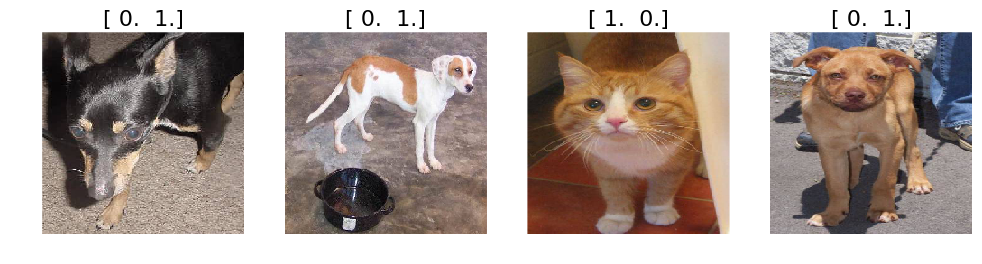

In [20]:
plots(imgs, titles=labels)

In [21]:
vgg.model.predict(imgs)

array([[  2.4669e-10,   1.0000e+00],
       [  2.2946e-08,   1.0000e+00],
       [  1.0000e+00,   1.4499e-09],
       [  3.8556e-10,   1.0000e+00]], dtype=float32)

We can now pass the images to Vgg16's predict() function to get back probabilities, category indexes, and category names for each image's VGG prediction.

In [22]:
vgg.predict(imgs, True)

(array([ 1.,  1.,  1.,  1.], dtype=float32),
 array([1, 1, 0, 1]),
 ['dogs', 'dogs', 'cats', 'dogs'])

The category indexes are based on the ordering of categories used in the VGG model - e.g here are the first four:

In [23]:
vgg.classes

['cats', 'dogs']

(Note that, other than creating the Vgg16 object, none of these steps are necessary to build a model; they are just showing how to use the class to view imagenet predictions.)

## Use vgg16 to predict test images
Must have test images inside a subdirectory for batch generation. I put them in test/images/

In [28]:
test_batches, test_predictions = vgg.test('data/dogscatsredux/test', batch_size=8)

Found 12500 images belonging to 1 classes.


Class probablities (cats, dogs) of the first batch

In [30]:
test_predictions[0:8]

array([[  1.0000e+00,   7.1777e-07],
       [  2.5434e-01,   7.4566e-01],
       [  1.0000e+00,   4.4585e-06],
       [  1.0000e+00,   1.9752e-09],
       [  8.9258e-10,   1.0000e+00],
       [  1.0724e-05,   9.9999e-01],
       [  1.0000e+00,   1.9082e-09],
       [  2.2715e-02,   9.7728e-01]], dtype=float32)

In [31]:
dogs_prob = test_predictions[:,1]
dogs_prob[0:8]

array([  7.1777e-07,   7.4566e-01,   4.4585e-06,   1.9752e-09,   1.0000e+00,   9.9999e-01,
         1.9082e-09,   9.7728e-01], dtype=float32)

getting filenames of the images

In [40]:
filenames = test_batches.filenames
filenames[:9]

['test/9292.jpg',
 'test/12026.jpg',
 'test/9688.jpg',
 'test/4392.jpg',
 'test/779.jpg',
 'test/2768.jpg',
 'test/2399.jpg',
 'test/12225.jpg',
 'test/10947.jpg']

## Writing kaggle csv file

In [33]:
import re

In [34]:
def ids_from_filenames(filenames):
    """
    Extract the ids of Kaggle test images from their filenames
    """
    
    num_files= len(filenames)
    ids = range(num_files)
    pattern = re.compile(r"\d+")

    for i in range(num_files):
        match = pattern.search(filenames[i])
        ids[i] = match.group()
    return ids

In [89]:
import pandas as pd
def kaggle_csv(filenames, dog_probs):
    """
    Create csv submission file according to dogs vs cats redux competition
    For each image in the test set, write row with two cells:
    First cell has the id of the image.
    Second cell has the probability that image is a dog.
    """
    ids = [int(x) for x in ids_from_filenames(filenames)]
    
    labels = ['{:.1f}'.format(x) for x in dog_probs]

    df = pd.DataFrame({"id": ids, "label": labels})
    df = df.sort_values('id')    
    df.to_csv("kaggle-submit.csv", index=False)
    
kaggle_csv(filenames, dogs_prob)

In [103]:
!head kaggle-submit.csv

id,label
1,1.0
2,1.0
3,1.0
4,1.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


showing the first 9 images

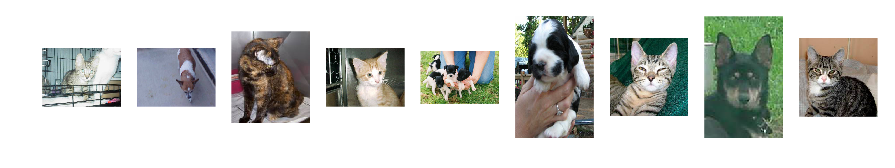

In [43]:
from keras.preprocessing import image

img = list()
for i in range(9):
    img.append(image.load_img(path='data/dogscatsredux/test/'+filenames[i]))

plots(img)

## Submit results to kaggle

In [45]:
!kg submit kaggle-submit.csv -u ohassan -p 1etmeinBaby -c dogs-vs-cats-redux-kernels-edition

Starting new HTTPS connection (1): www.kaggle.com



In [46]:
!pwd

/home/ubuntu/fastai_courses/deeplearning1/nbs


# Now working on the whole dataset

In [47]:
path = "data/dogscatsredux/"

In [9]:
# As large as you can, but no larger than 64 is recommended. 
# If you have an older or cheaper GPU, you'll run out of memory, so will have to decrease this.
batch_size=64

In [10]:
# Import our class, and instantiate
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [49]:
vgg = Vgg16()
# Grab a few images at a time for training and validation.
# NB: They must be in subdirectories named based on their category
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=2*batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [50]:
vgg.finetune(batches)

In [65]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 648s - loss: 0.2204 - acc: 0.9756 - val_loss: 0.1285 - val_acc: 0.9875


## Saving model weights

In [66]:
weights_fpath = 'vgg-weights-1.h5'

In [67]:
vgg.model.save_weights(weights_fpath)
#vgg.model.load_weights(weights_fpath)

## Use vgg16 to predict test images
Must have test images inside a subdirectory for batch generation. I put them in test/images/

In [68]:
test_batches, test_predictions = vgg.test('data/dogscatsredux/test', batch_size=8)

Found 12500 images belonging to 1 classes.


Class probablities (cats, dogs) of the first batch

In [69]:
dogs_prob = test_predictions[:,1]

getting filenames of the images

In [71]:
filenames = test_batches.filenames
#filenames[:9]

## Writing kaggle csv file

In [93]:
kaggle_csv(filenames, dogs_prob)

In [104]:
!head kaggle-submit.csv

id,label
1,1.0
2,1.0
3,1.0
4,1.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


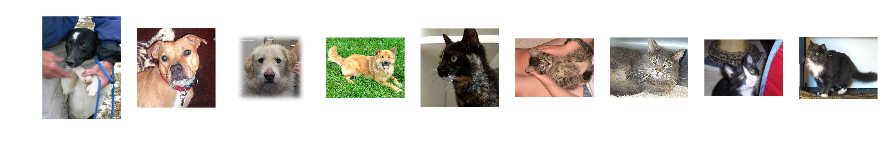

In [100]:
img = list()
for i in range(1, 10): 
    img.append(image.load_img(path='data/dogscatsredux/test/test/'+str(i)+'.jpg'))

plots(img)

## Testing predictions for 4 images

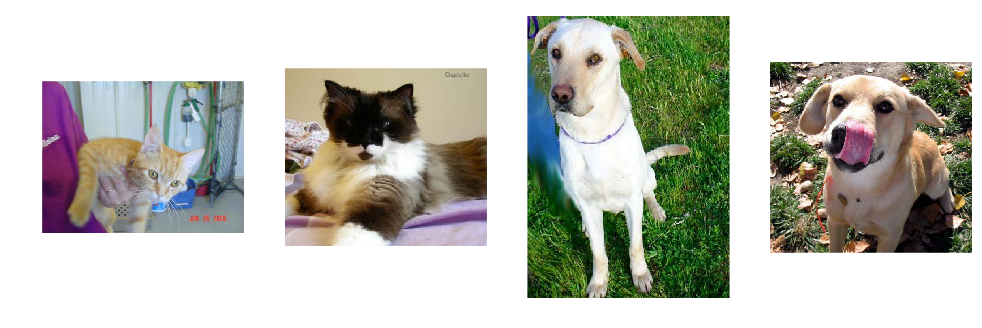

In [74]:
from keras.preprocessing import image

x = 300 # Any 4 images
img = list()
for i in range(x, x+4): 
    img.append(image.load_img(path='data/dogscatsredux/test/'+filenames[i]))

plots(img)

In [75]:
dogs_prob[x : x+4]

array([  8.6353e-23,   7.5696e-19,   1.0000e+00,   1.0000e+00], dtype=float32)

In [76]:
['{:.1f}'.format(i) for i in dogs_prob[x : x+4]]

['0.0', '0.0', '1.0', '1.0']

## Submit results to kaggle

In [96]:
!kg submit kaggle-submit.csv -u ohassan -p 1etmeinBaby -c dogs-vs-cats-redux-kernels-edition

Starting new HTTPS connection (1): www.kaggle.com

